*Contributed by: Kimberly*

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl
import seaborn as sns
from sklearn.neighbors import KernelDensity

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score

In [2]:
train = pd.read_csv('../assets/train_final.csv')
test = pd.read_csv('../assets/test_final.csv')
spray = pd.read_csv('../assets/spray_cleaned.csv')
map_df = np.loadtxt("../assets/mapdata_copyright_openstreetmap_contributors.txt")

## Chosen Model: Logistic Regression

In [3]:
# Define X and y for model.
X = train.drop(columns = ['WnvPresent','NumMosquitos'])._get_numeric_data()
X_kaggle_test = test._get_numeric_data()
y = train['WnvPresent']

In [4]:
#perform train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

In [5]:
ss = StandardScaler()
ss.fit(X_train)

X_train_ss = ss.transform(X_train)
X_test_ss = ss.transform(X_test)

In [6]:
smt = SMOTE(random_state=42)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

# Performing Standard Scaling on our dataset 
X_train_smt_ss = ss.fit_transform(X_train_smt)
X_kaggle_test_ss = ss.fit_transform(X_kaggle_test)

In [7]:
lr = LogisticRegression(C=10, max_iter=10000, random_state=42)
lr.fit(X_train_smt_ss, y_train_smt)
lr.score(X_train_smt_ss, y_train_smt)

0.7583955223880597

## Kaggle Submission

In [8]:
predictions = lr.predict(X_kaggle_test_ss)
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [9]:
pred_proba = lr.predict_proba(X_kaggle_test_ss)
pred_proba

array([[0.99640789, 0.00359211],
       [0.99822317, 0.00177683],
       [0.99391677, 0.00608323],
       ...,
       [0.93239198, 0.06760802],
       [0.93239198, 0.06760802],
       [0.93239198, 0.06760802]])

In [10]:
pred_proba_t = [i[1] for i in pred_proba]

In [11]:
test_id = test.index

In [12]:
kaggle_sub = pd.DataFrame()
kaggle_sub['Id'] = test_id + 1
kaggle_sub['WnvPresent'] = pred_proba_t
kaggle_sub

,Id,WnvPresent
0,1,0.003592
1,2,0.001777
2,3,0.006083
3,4,0.001249
4,5,0.001249
...,...,...
116288,116289,0.067608
116289,116290,0.067608
116290,116291,0.067608
116291,116292,0.067608


In [13]:
#Export for kaggle submission
kaggle_sub.to_csv('../assets/kaggle.csv', index=False)

<img src="../assets/kaggle_score.png" width="800">

The model has a 70% chance of distinguishing between the positive and negative class. With such an imbalanced dataset and imperfect industry knowledge, we find this score rather reasonable. 

## Evaluation

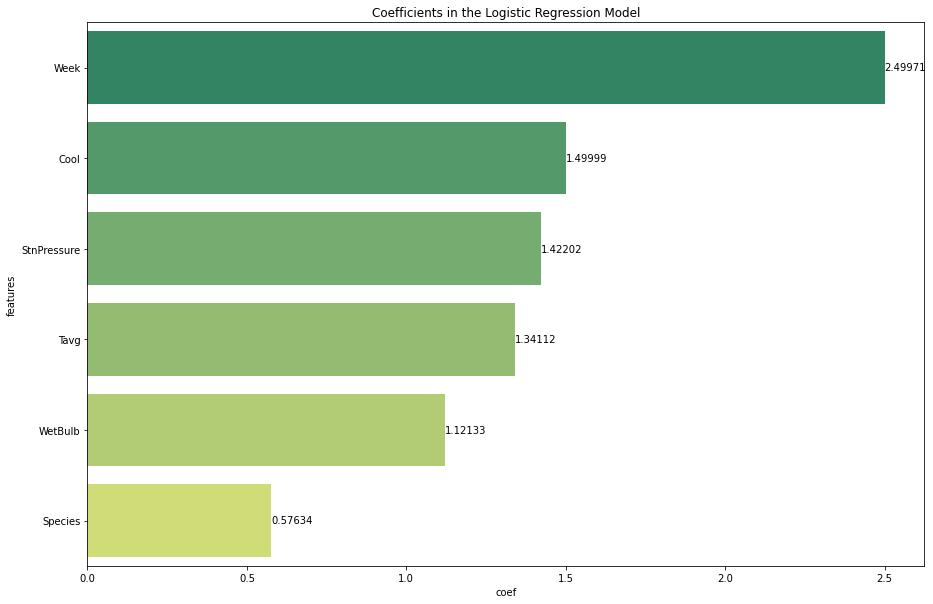

In [32]:
#Important coefficients
lr_coef = pd.DataFrame(zip(X_train_smt.columns, np.transpose(lr.coef_.tolist()[0])), columns=['features', 'coef'])
lr_coef['abs'] = abs(lr_coef['coef'])
lr_imp_coef = lr_coef.sort_values(by=['coef']).tail(6)
plt.figure(figsize=(15,10))
ax = sns.barplot(x='coef', y='features', data=lr_imp_coef.sort_values(by='coef',ascending=False), palette='summer')
ax.bar_label(ax.containers[0])
plt.title("Coefficients in the Logistic Regression Model");

Top features in determining if the WNV is present:
1. Week
2. Cool
3. StnPressure - relating to altitude
4. Tavg
5. WetBulb - accounts for both heat and humidity; 
6. Species

These features illustrate that the week, higher temperatures and humidity does increase the probability of the West Nile Virus. A simple comparison with the pvalues by StatsModel show that these 6 features (except wet bulb) are statistically significant with p-value less than 0.05. Creating another feature incorporating the difference between Tavg and WetBulb may improve it's significance as it would be a measure of humidity.

In [15]:
import statsmodels.api as sm
logit_model=sm.Logit(y_train,X_train)
result=logit_model.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.167024
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             WnvPresent   No. Observations:                 7354
Model:                          Logit   Df Residuals:                     7320
Method:                           MLE   Df Model:                           33
Date:                Sat, 26 Feb 2022   Pseudo R-squ.:                  0.1883
Time:                        03:03:02   Log-Likelihood:                -1228.3
converged:                       True   LL-Null:                       -1513.3
Covariance Type:            nonrobust   LLR p-value:                 3.867e-99
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
Species             0.1618      0.026      6.346      0.000       0.112       0.212
Block        

In [16]:
# Generating the confusion matrix
cm = confusion_matrix(y_test, lr.predict(X_test_ss))
tn, fp, fn ,tp = cm.ravel()
pd.DataFrame(cm, columns = ["pred neg_WNV", "pred pos_WNV"], index=["actual neg_WNV", "actual pos_WNV"])

,pred neg_WNV,pred pos_WNV
actual neg_WNV,1449,1538
actual pos_WNV,21,144


The confusion matrix shows that there are many false positive predictions of WNV. This model would be too conservative in predicting areas for spraying as it overcompensates the area. This also shows that the current features are still insufficient to predict WNV clusters as other cases with similar factors would be predicted positive, resulting in more cost spent in spraying areas that may not necessarily need them. 

## Evaluating Sprays based on occurence

In [17]:
spray['Date'] = pd.to_datetime(spray['Date'])
spray['Year'] = (spray['Date'].dt.strftime('%Y')).astype(int)
spray['Month'] = (spray['Date'].dt.month.astype(int))
spray['Week'] = (spray['Date'].dt.strftime('%W')).astype(int)
spray['Day'] = (spray['Date'].dt.day.astype(int))

train_2013 = train[train['Year']==2013]
spray_2013 = spray[spray['Year']==2013]

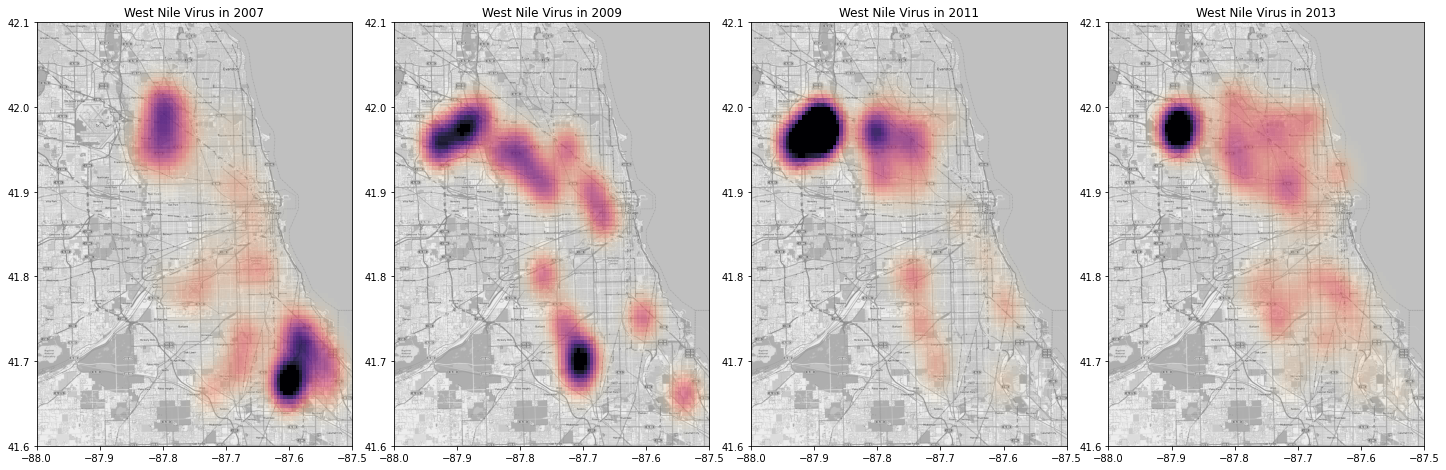

In [18]:
#Code referenced from: https://github.com/wilsonkwa
# Map trap and west nile heatmap 
fig, ax1 = plt.subplots(figsize = (20,9),nrows = 1, ncols = 4, sharey = False)
fig.tight_layout()
for idx, year in enumerate(train['Year'].unique()):
    # Show map in desired lat, long range 
    axis = ax1[idx]
    axis.imshow(map_df, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
               aspect = map_df.shape[0] * 1.0 / map_df.shape[1])
        
    # Plot a density map of West Nile Virus sighting
    bounds = np.arange(50)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256,extend='max')
    alphas = plt.cm.magma_r
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = train[['Longitude','Latitude']][(train['WnvPresent'] == 1) & (train['Year'] == year)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axis.imshow(zv,
                origin = 'lower',
                cmap = alphas,
                extent = (-88, -87.5, 41.6, 42.1),
                aspect = map_df.shape[0]*1.0/map_df.shape[1],
                norm=norm)
    # Labels
    axis.set_title(f"West Nile Virus in {year}");

/var/folders/pf/rrh9p6sx2dd51926v2m3hf9m0000gn/T/ipykernel_37365/1370232265.py:46: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show();


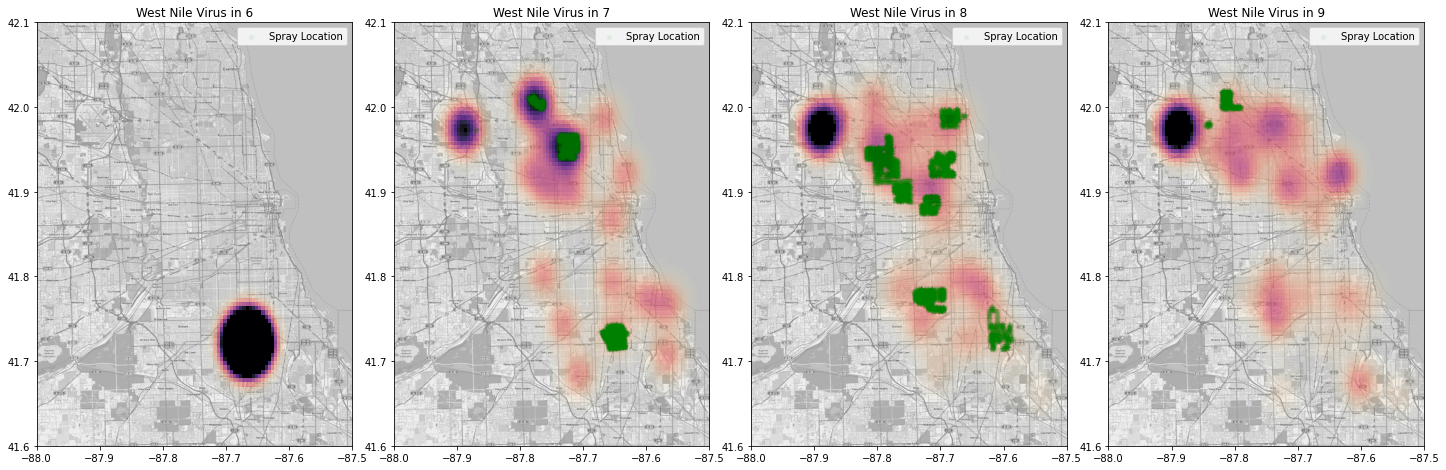

In [19]:
# Map trap and west nile heatmap 
fig, ax1 = plt.subplots(figsize = (20,9),nrows = 1, ncols = 4, sharey = False)
fig.tight_layout()
for idx, month in enumerate(train_2013['Month'].unique()):
    # Show map in desired lat, long range 
    axis = ax1[idx]
    axis.imshow(map_df, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
               aspect = map_df.shape[0] * 1.0 / map_df.shape[1])
        
    # Plot a density map of West Nile Virus sighting
    bounds = np.arange(50)
    norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256,extend='max')
    alphas = plt.cm.magma_r
    alphas._init()
    alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
    virus_locs = train_2013[['Longitude','Latitude']][(train_2013['WnvPresent'] == 1) & (train_2013['Month'] == month)]
    kern = KernelDensity(bandwidth = 0.02)
    kern.fit(virus_locs.values)
    xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
    gridpoints = np.array([xv.ravel(), yv.ravel()]).T
    zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
    axis.imshow(zv,
                origin = 'lower',
                cmap = alphas,
                extent = (-88, -87.5, 41.6, 42.1),
                aspect = map_df.shape[0]*1.0/map_df.shape[1],
                norm=norm)
    # Scatter plot for spray locations (removing outliers far away from the rest of the traps)
    spray_loc = spray_2013[['Longitude', 'Latitude','Month']].drop_duplicates()
    current = spray_loc[spray_loc['Month']==month]
    axis.scatter(current['Longitude'], current['Latitude'], marker = '*', color = 'g', label = "Spray Location", alpha=0.05)
    # Labels
    axis.set_title(f"West Nile Virus in {month}")
    axis.legend();
    
# fig, ax2 = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)

# cmap = mpl.cm.magma_r
# bounds = np.arange(50)
# norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256,extend='max')

# cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap,
#                                 norm=norm,
#                                 orientation='horizontal')
fig.show();

In [20]:
train_2013['WnvPresent'].loc[(train_2013['Month']==6)].value_counts()

0    435
1      1
Name: WnvPresent, dtype: int64

In [21]:
train_2013['WnvPresent'].loc[(train_2013['Month']==8)].value_counts()

0    690
1    144
Name: WnvPresent, dtype: int64

In [22]:
train_2013['WnvPresent'].loc[(train_2013['Month']==8)&((train_2013['Longitude']<=-87.85)&(train_2013['Longitude']>=-87.95))].value_counts()

0    76
1    32
Name: WnvPresent, dtype: int64

Note: the darkness of the circle does not denote the magnitude of the cases. 

The above KDE plotted by Month, shows the **probability density** which would suggest a possible cluster at the darker regions. We can note from the monthly and weekly plots, the sprays are done strategically at denser areas after monitoring. This would definitely be more cost-effective than spraying broadly at a huge area.

<img src="../assets/2013_weekly.gif" height="250" />

However, there is one spot that does not seem to be touched. The O'Hare International Airport! We can see a high probability of a cluster at the airport across the years. This should be a potential concern for the airport to conduct vector control measures. Several studies ([link1](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3319934/),[link2](https://www.who.int/bulletin/archives/78(8)995.pdf)) have also shown the transport of WNV-infected mosquitos aboard aircrafts making the spread of these vectors more prevalent as the world gets more interconnected through air travel. 
<img src="../assets/41.99,-87.77.png" width="500">

## Recommendations for spraying

In [23]:
pred_df = pd.merge(kaggle_sub,test,left_index=True, right_index=True)
pred_df.shape

(116293, 37)

In [24]:
pred_df.head()

,Id,WnvPresent,Species,Block,Trap,Latitude,Longitude,AddressAccuracy,Year,Month,...,T115,T002,T138,T003,T128,T225,T011,T903,T013,T008
0,1,0.003592,6.0,41,T002,41.95469,-87.800991,9,2008,6,...,0,1,0,0,0,0,0,0,0,0
1,2,0.001777,2.0,41,T002,41.95469,-87.800991,9,2008,6,...,0,1,0,0,0,0,0,0,0,0
2,3,0.006083,9.0,41,T002,41.95469,-87.800991,9,2008,6,...,0,1,0,0,0,0,0,0,0,0
3,4,0.001249,0.0,41,T002,41.95469,-87.800991,9,2008,6,...,0,1,0,0,0,0,0,0,0,0
4,5,0.001249,0.0,41,T002,41.95469,-87.800991,9,2008,6,...,0,1,0,0,0,0,0,0,0,0


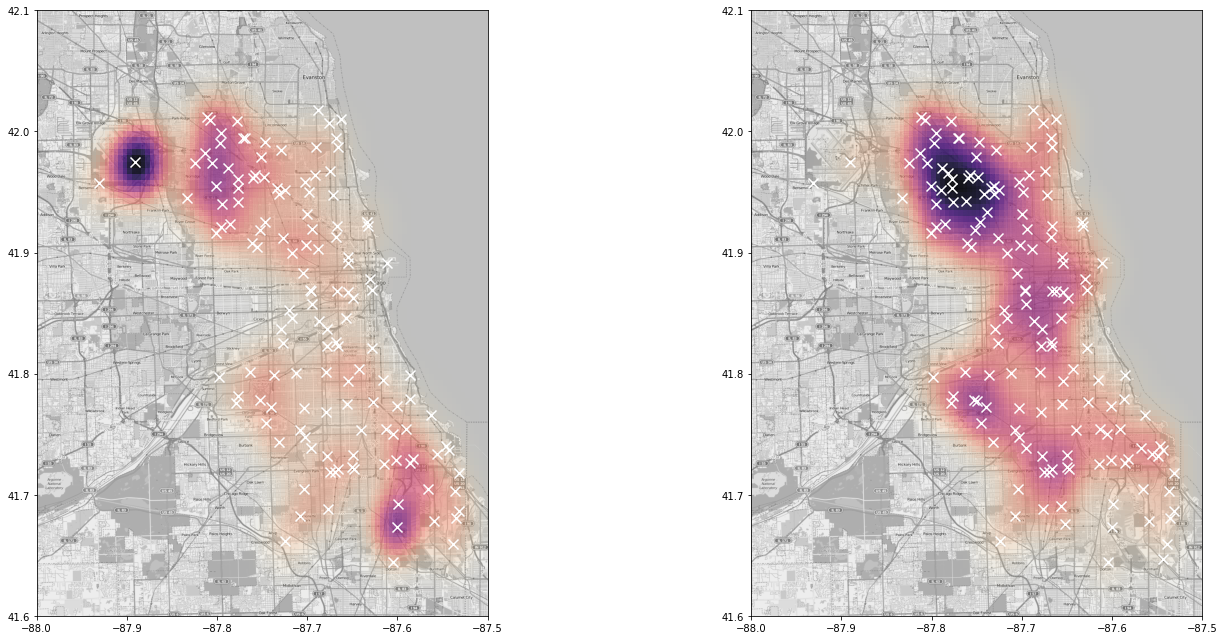

In [25]:
# Map trap and west nile heatmap 
def plot_graph(col,df_list):
    fig, axs = plt.subplots(figsize = (20,9),nrows = 1, ncols = col, sharey = False)
    fig.tight_layout()
    
    for idx, df in enumerate(df_list):
        # Show map in desired lat, long range 
        axis = axs[idx]
        axis.imshow(map_df, cmap = plt.get_cmap('gray'), extent = (-88, -87.5, 41.6, 42.1),
                   aspect = map_df.shape[0] * 1.0 / map_df.shape[1])

        # Scatter plot for trap locations 
        trap_df = df[['Trap','Longitude','Latitude']].drop_duplicates("Trap")
        axis.scatter(trap_df.values[:,1], 
                     trap_df.values[:,2],
                     s=100,marker='x', c='white', alpha=1, label='Trap')

        # Plot a density map of West Nile Virus sighting
        alphas = plt.cm.magma_r
        alphas._init()
        alphas._lut[:-3, -1] = abs(np.logspace(0,1,alphas.N) / 10 - 1)[::-1]
        virus_locs = df[['Longitude','Latitude']][(df['WnvPresent'] > 0.5)]
        kern = KernelDensity(bandwidth = 0.02)
        kern.fit(virus_locs.values)
        xv, yv = np.meshgrid(np.linspace(-88, -87.5, 100), np.linspace(41.6, 42.1, 100))
        gridpoints = np.array([xv.ravel(), yv.ravel()]).T
        zv = np.exp(kern.score_samples(gridpoints).reshape(100,100))
        axis.imshow(zv,
                   origin = 'lower',
                   cmap = alphas,
                   extent = (-88, -87.5, 41.6, 42.1),
                   aspect = map_df.shape[0]*1.0/map_df.shape[1]);
    
plot_graph(2,[train,pred_df])

<img src="../assets/kde.gif" height="250" />

### When to spray?
* Based on the EDA, we can note that peak WNV is detected in August. Early spraying from mid-June at known hot spots would be beneficial.

### Where to spray?
* Both train data and predicted data depict the north side of Chicago as a hot spot for WNV. It can be seen that the residential area is surronded by the woods on both fronts which might be a contributing factor for the high probability of the virus 
* Areas near still water bodies should be a priority
* Airports should include vector control measures due to liability of importing and exporting WNV-infected mosquitos

## Cost-Benefit Analysis

[Chicago WNV human cases:](https://www.chicago.gov/content/dam/city/depts/cdph/food_env/general/West_Nile_Virus/WNV_2018databrief_FINALJan102019.pdf)<img src="../assets/chicago_wnv_human.png" width="500">

Current efforts in Chicago has seen a great decline in WNV human cases since its first introduction in 2002. 

([Health Statistics](https://www.modernhealthcare.com/article/20140211/NEWS/302119972/west-nile-virus-has-cost-u-s-almost-800-million-study-says)) show that 80% of those infected with WNV devlop no symptoms and 1 in 150 of those infected would develop more sever complications requiring hospitalisation.\
Short-term cost: 7.5k USD\
Long-term cost (due to complications): 25k USD.

Spraying estimates:\
[Spray rate](https://www.nbcchicago.com/news/local/city-to-spray-mosquito-killing-insecticide-wednesday-night/64951/): 1.5s ounce / acre\
[Zenivex quote](http://www.gfmosquito.com/wp-content/uploads/2017/07/2017-ND-Mosq.-Control-Quotes-Tabulation.pdf): 300 USD per gallon (1 gallon = 128 ounces)\
[Mosquito treament cost](https://www.callnorthwest.com/2020/05/how-much-does-a-mosquito-treatment-cost/): 350-500 USD per 1/4 - 1/2 acre\
Chicago size: 149,800 acres\
Spraying costs: assume 1k per acre, 50% spray coverage would cost approx. 75 million.

With low levels of infection, large-scale pesticide spraying is not warranted due to its high costs and concerns of its environmental impact. The current strategy to evaluate neccessary sites for spraying based on weekly WNV surveillance reports is sufficient.

## Conclusion and Recommendations

The chosen logistic regression model is able to successfully distinguish the presence of WNV with a proability of 70%. Given weather and mosquito data, the model will be able to predict locations with high risk. 

Further steps required would include further tuning of the model to reduce misclassification. This would increase cost savings in areas identified as high-risk and in need of pesticide spraying. More data on infected patient clusters, other environment factors (e.g. bird clusters, water bodies) and other vector control methods (e.g. catch basins with larvicide) would help narrow the scope of spraying too.

Other recommendations include house inspections for possible breeding grounds for mosquitos and to provide education to homeowners on how to best manage their property. Community support is also necessary for vector control especially on private properties.